This script generates a bar plot using data from a CSV file. The plot compares different methods and their performance on various functions.

The script performs the following steps:

1. Reads the data from the CSV files.
2. Prepares the data by dropping unnecessary columns and setting the index.
3. Reorders the columns based on a predefined order.
4. Renames columns for better readability.
5. Defines bar positions and width.
6. Creates the plot by plotting each set of bars.
7. Sets the plot settings such as title, labels, and legend.
8. Displays the plot.


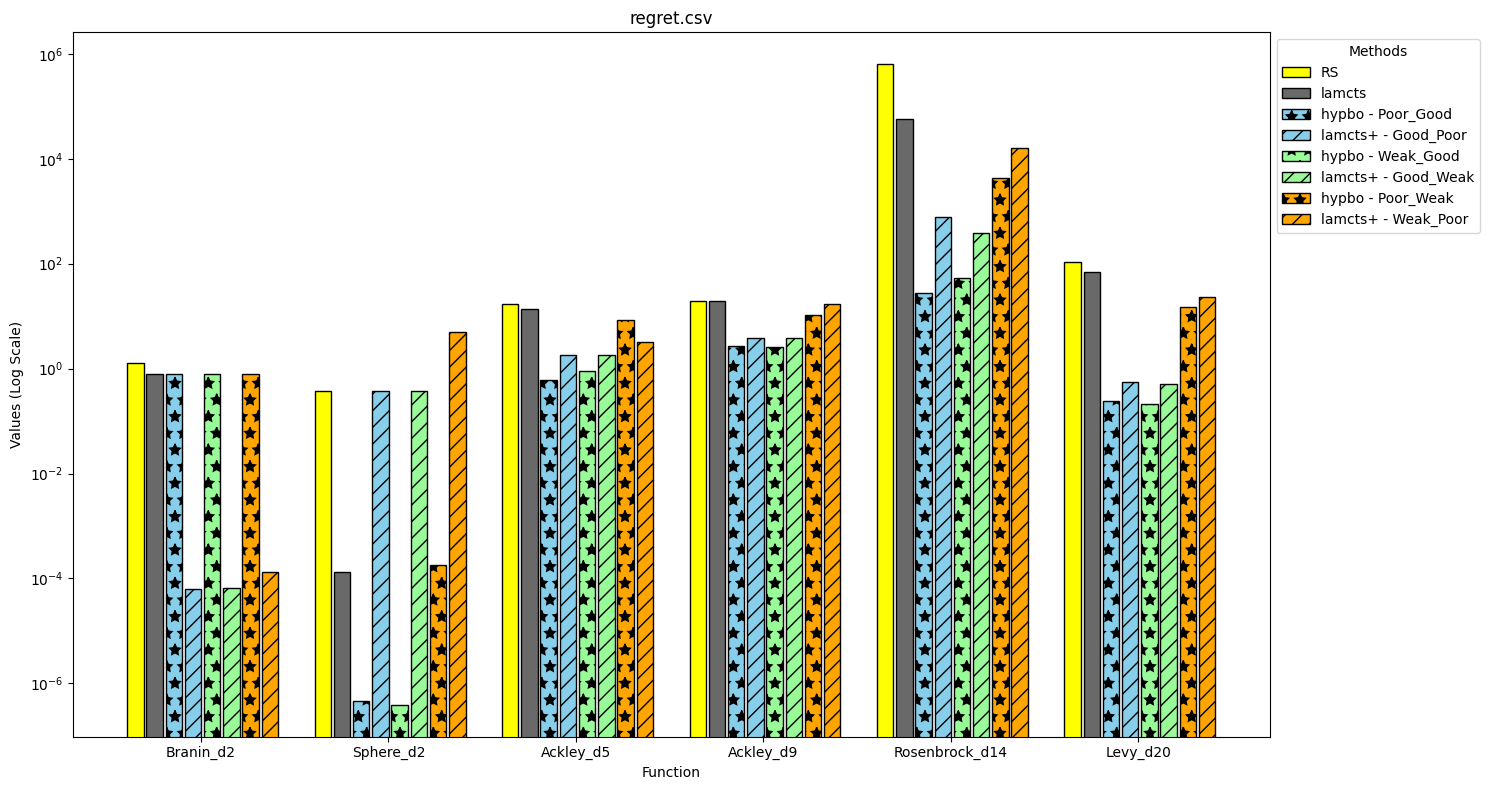

In [3]:
from calendar import c
import matplotlib.pyplot as plt
import pandas as pd

single_hypothesis = False

# Read the data from the csv files.
file_path = 'regret.csv'
data = pd.read_csv(file_path)
std_data = pd.read_csv('regret_std_cum.csv')

# Preparing the data.
data = data.drop(data.columns[0], axis=1)  # Drop the first unnamed column.

colors = []
# Order of the columns to keep in the plot.
ordered_columns = [
    ('random_search - No Hypothesis', 'yellow'),
    ('lamcts - No Hypothesis', 'dimgrey')
]
if single_hypothesis:
    ordered_columns += [
        ('hypbo - Good', 'palegreen'),
        ('lamcts+ - Good', 'palegreen'),
        ('pibo - Good', 'palegreen'),
        ('hypbo - Weak', 'orange'),
        ('lamcts+ - Weak', 'orange'),
        ('pibo - Weak', 'orange'),
        ('hypbo - Poor', 'tomato'),
        ('lamcts+ - Poor', 'tomato'),
        ('pibo - Poor', 'tomato')
    ]
else:
    ordered_columns += [
        ('hypbo - Poor_Good', 'skyblue'),
        ('lamcts+ - Good_Poor', 'skyblue'),
        ('hypbo - Weak_Good', 'palegreen'),
        ('lamcts+ - Good_Weak', 'palegreen'),
        ('hypbo - Poor_Weak', 'orange'),
        ('lamcts+ - Weak_Poor', 'orange')
    ]
ordered_columns, colors = zip(*ordered_columns)
ordered_columns = list(ordered_columns)
colors = list(colors)

# Drop columns that are not in the ordered columns.
for column in data.columns:
    if column not in ordered_columns and column != 'Function':
        data = data.drop(column, axis=1)
        std_data = std_data.drop(column, axis=1)
data = data.set_index('Function')  # Set 'Function' as index.
std_data = std_data.set_index('Function')  # Set 'Function' as index.

# Reorder the data with sorted columns.
data = data[ordered_columns]
std_data = std_data[ordered_columns]

# Rename the column 'random_search - No Hypothesis' to 'RS'.
data = data.rename(columns={'random_search - No Hypothesis': 'RS'})
data = data.rename(columns={'lamcts - No Hypothesis': 'lamcts'})
std_data = std_data.rename(columns={'random_search - No Hypothesis': 'RS'})
std_data = std_data.rename(columns={'lamcts - No Hypothesis': 'lamcts'})

# Define bar positions and width.
bar_width = 0.7 / len(data.columns)
bar_positions = {}

# Creating the plot.
plt.figure(figsize=(15, 8))
ax = plt.gca()
ax.set_yscale('log')

# Plot each set of bars
# The desired space between groups of bars, in pixels
space_in_pixels = 1.5
dpi = plt.gcf().dpi  # Get the figure's resolution in dots per inch
space = space_in_pixels / dpi  # Convert pixels to coordinates
for i, (method, color) in enumerate(zip(data.columns, colors)):
    hatch = '//' if 'lamcts+' in method else (
        'o' if 'pibo' in method else ('*' if 'hypbo' in method else None))
    bar_position_with_space = [
        x + (bar_width + space) * i for x in range(len(data))]
    plt.bar(bar_position_with_space, data[method],
            width=bar_width, label=method, color=color, hatch=hatch,
            edgecolor='black', linewidth=1,  # Bar border
            # yerr=std_data[method], capsize=5  # Uncomment to add error bars
            )

# Final plot settings
plt.title(file_path)
plt.ylabel('Values (Log Scale)')
plt.xlabel('Function')
plt.xticks([r + len(data.columns) // 2 * bar_width for r in range(len(data))],
           data.index, rotation=0)
plt.legend(title='Methods', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

In [5]:
"""
This script performs a Wilcoxon signed-rank test between different methods using the given data.
It calculates the p-values resulting from the test and displays the mean and median cumulative regrets for each method.
"""

from scipy.stats import wilcoxon


def perform_wilcoxon_test(df, method1, method2):
    """
    Perform Wilcoxon signed-rank test between two methods.

    Parameters:
    - df (DataFrame): The data containing the methods' results.
    - method1 (str): The first method to compare.
    - method2 (str): The second method to compare.

    Returns:
    - p (float): The p-value resulting from the Wilcoxon signed-rank test.
    """
    data1 = df[method1].dropna()
    data2 = df[method2].dropna()
    if len(data1) == 0 or len(data2) == 0:
        return None
    stat, p = wilcoxon(data1, data2)
    return p


p_values = {}


hypbo_variants = []
if single_hypothesis:
    hypbo_variants = ["hypbo - Poor", "hypbo - Weak", "hypbo - Good"]
else:
    hypbo_variants = ["hypbo - Poor_Good",
                      "hypbo - Weak_Good", "hypbo - Poor_Weak"]
methods = [col for col in ordered_columns if col not in hypbo_variants]
methods = [col.replace('random_search - No Hypothesis', 'RS').replace(
    'lamcts - No Hypothesis', 'lamcts') for col in methods]   # Rename methods


for hypbo in hypbo_variants:
    for method in methods:
        if method != hypbo:
            p_value = perform_wilcoxon_test(data, hypbo, method)
            if p_value is not None:
                p_values[(hypbo, method)] = p_value


p_values_df = pd.DataFrame([(k[0], k[1], v) for k, v in p_values.items()], columns=[
                           'HypBO Variant', 'Method', 'p-value'])


mean_values = data.mean()
median_values = data.median()


print("Mean Cumulative Regrets:\n", mean_values)
print("\nMedian Cumulative Regrets:\n", median_values)


print("\nWilcoxon Signed-Rank Test P-Values:")
p_values_df_sorted = p_values_df.sort_values(by=['HypBO Variant', 'p-value'])
print(p_values_df_sorted)

Mean Cumulative Regrets:
 RS                     105252.735291
lamcts                   9630.210970
hypbo - Poor_Good           5.321859
lamcts+ - Good_Poor       128.551460
hypbo - Weak_Good           9.704495
lamcts+ - Good_Weak        66.023177
hypbo - Poor_Weak         735.910852
lamcts+ - Weak_Poor      2736.418514
dtype: float64

Median Cumulative Regrets:
 RS                     18.045813
lamcts                 16.468339
hypbo - Poor_Good       0.694777
lamcts+ - Good_Poor     1.203269
hypbo - Weak_Good       0.845940
lamcts+ - Good_Weak     1.178657
hypbo - Poor_Weak       9.422065
lamcts+ - Weak_Poor    10.925469
dtype: float64

Wilcoxon Signed-Rank Test P-Values:
        HypBO Variant               Method  p-value
0   hypbo - Poor_Good                   RS  0.03125
1   hypbo - Poor_Good               lamcts  0.03125
4   hypbo - Poor_Good  lamcts+ - Weak_Poor  0.06250
2   hypbo - Poor_Good  lamcts+ - Good_Poor  0.15625
3   hypbo - Poor_Good  lamcts+ - Good_Weak  0.15625
10  hy